In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('../data/processed/wfp_preprocessed.parquet')

# Convert 'date' column to datetime (if it isn't already)
df['date'] = pd.to_datetime(df['date'], errors='coerce') 

# Extract the year from the 'date' column and create a new 'year' column
df['year'] = df['date'].dt.year.astype(int)

df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,countryiso3,country,Value,Unit,standardprice,year
0,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,cereals and tubers,Maize meal,KG,actual,Retail,SZL,8.94,0.8232,SWZ,Eswatini,1.0,1 KG,0.8232,2014
1,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,cereals and tubers,Rice,KG,actual,Retail,SZL,10.79,0.9936,SWZ,Eswatini,1.0,1 KG,0.9936,2014
2,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,cereals and tubers,Wheat flour,KG,actual,Retail,SZL,11.85,1.0912,SWZ,Eswatini,1.0,1 KG,1.0912,2014
3,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,miscellaneous food,Sugar (brown),KG,actual,Retail,SZL,10.21,0.9401,SWZ,Eswatini,1.0,1 KG,0.9401,2014
4,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,pulses and nuts,Beans (sugar),KG,actual,Retail,SZL,24.50,2.2560,SWZ,Eswatini,1.0,1 KG,2.2560,2014


In [3]:
print(df['commodity'].unique())

['Maize meal' 'Rice' 'Wheat flour' 'Sugar (brown)' 'Beans (sugar)' 'Bread'
 'Bread (brown)' 'Salt' 'Cabbage' 'Potatoes' 'Maize (white)'
 'Oil (sunflower)' 'Oil (cooking)' 'Rice (mixed, low quality)' 'Soybeans'
 'Prawn' 'Meat (pork, with fat)' 'Oil (vegetable)' 'Eggs (duck)'
 'Beans (yardlong, green)' 'Cabbage (chinese, flowering)'
 'Fish (snake head)' 'Fish (striped catfish)' 'Salt (iodised)' 'Wax gourd'
 'Fish (catfish)' 'Eggplants' 'Snake gourd' 'Water spinach'
 'Eggs (duck, fermented)' 'Fish (snake head, dry)' 'Fish sauce (lobster)'
 'Bean (mung, dry)' 'Groundnuts' 'Soybeans (dry)' 'Bananas (ripe)'
 'Garlic' 'Tamarind (ripe)' 'Meat (beef, fat, without bones)'
 'Meat (chicken)' 'Bananas flower' 'Cauliflower'
 'Eggplants (white, round)' 'Gourd (ridge)' 'Papaya (green)'
 'Tomatoes (red, ripe)' 'Fish paste (red, fermented)'
 'Cabbage (chinese, raw)' 'Ivygourd leaves' 'Kale (chinese)'
 'Moringa leaves' 'Mustard leaves' 'Pumpkin leaves' 'Sauropus sp. leaves'
 'Carrots' 'Pumpkin' 'Amaranth

In [4]:
print(df['Unit'].unique())

['1 KG' 'Head' '1 L' '1 Dozen' '1 Tuber' 'Bunch' 'Packet' '1 piece' 'Unit'
 'Box' 'Heap' 'Day' 'Bundle' 'Package' 'Pile' 'Marmite' 'Cuartilla']


In [5]:
pd.set_option('display.max_rows', None)
commodity_units = df.groupby(['country', 'commodity', 'Unit'])['standardprice'].mean().reset_index()
print(commodity_units[commodity_units['Unit'] == '1 Dozen'])

          country               commodity     Unit  standardprice
20        Algeria                    Eggs  1 Dozen       0.121182
82        Armenia                    Eggs  1 Dozen       0.148068
113    Bangladesh            Eggs (brown)  1 Dozen       0.104426
114    Bangladesh            Eggs (white)  1 Dozen       0.104218
228       Bolivia                    Eggs  1 Dozen       0.105187
308      Cambodia             Eggs (duck)  1 Dozen       0.125718
309      Cambodia  Eggs (duck, fermented)  1 Dozen       0.159687
353      Cameroon                    Eggs  1 Dozen       0.157932
476      Colombia            Eggs (local)  1 Dozen       0.110740
477      Colombia        Eggs (white, AA)  1 Dozen       0.101071
614      Djibouti                    Eggs  1 Dozen       0.174195
741         Egypt                    Eggs  1 Dozen       0.104893
742         Egypt      Eggs (medium size)  1 Dozen       0.117013
811      Ethiopia                    Eggs  1 Dozen       0.185846
938       

In [6]:
# get adjusted national income per capita (USD) per country and year
nni = pd.read_csv('../data/raw/adjusted_net_national_income.csv')

# drop non-year columns
year_cols = [col for col in nni.columns if "[YR" in col] + ["Country Code"]
nni_filtered = nni[year_cols]

# melt the filtered DataFrame
nni_long = nni_filtered.melt(
    id_vars=["Country Code"],
    var_name="year",
    value_name="Adjusted NNI"
)

# clean up the 'year' column
nni_long['year'] = nni_long['year'].str.extract(r'(\d{4})')
nni_long['year'] = nni_long['year'].astype(int)

# drop rows where there's no NNI for that year
nni_long['Adjusted NNI'] = nni_long['Adjusted NNI'].replace('..', pd.NA)
nni_long = nni_long.dropna(subset=['Adjusted NNI'])

# change type
nni_long['Adjusted NNI'] = nni_long['Adjusted NNI'].astype(float)

nni_long.head()

,Country Code,year,Adjusted NNI
0,AFG,2009,403.411183
1,ALB,2009,3517.609153
2,DZA,2009,2960.306317
5,AGO,2009,1870.287448
7,ARG,2009,6808.995877


In [7]:
# calculate average standard price per country and year
avg_price = df.groupby(['country', 'countryiso3', 'year'])['standardprice'].mean().reset_index()

# outer join on 'countryiso3' = 'Country Code' and 'year' = 'year'
affordability_df = pd.merge(
    avg_price, 
    nni_long, 
    how='left', 
    left_on=['countryiso3', 'year'], 
    right_on=['Country Code', 'year']
)

affordability_df = affordability_df.drop(columns=['Country Code'])
affordability_df = affordability_df.dropna()
affordability_df.head()

,country,countryiso3,year,standardprice,Adjusted NNI
0,Afghanistan,AFG,2014,0.623119,575.916815
1,Afghanistan,AFG,2015,0.556338,548.968455
2,Afghanistan,AFG,2016,0.511449,484.890590
3,Afghanistan,AFG,2017,0.517257,497.406029
4,Afghanistan,AFG,2018,0.495619,466.570602


In [8]:
from sklearn.preprocessing import StandardScaler

# estimate annual food expense and annual food budget
affordability_df['est_annual_cost'] = affordability_df['standardprice'] * 15 * 52 # average 15 commodities per week
affordability_df['est_annual_budget'] = affordability_df['Adjusted NNI'] * 0.60 # assuming upper bound of 60% of annual income spent on food for lower income countries

# calculate the affordability ratio
affordability_df['affordability_ratio'] = affordability_df['est_annual_budget'] / affordability_df['est_annual_cost']

# find and filter out outliers
th = 5
# print(affordability_df[affordability_df['affordability_ratio'] > th])
affordability_df = affordability_df[affordability_df['affordability_ratio'] <= th]

# find the min and max affordability ratio in the dataset
min_ratio = affordability_df['affordability_ratio'].min()
max_ratio = affordability_df['affordability_ratio'].max()

# normalize affordability ratio to a 0-100 scale
affordability_df['affordability_index'] = 100 * (affordability_df['affordability_ratio'] - min_ratio) / (max_ratio - min_ratio)

# clip values to 0-100 range in case of any outliers
affordability_df['affordability_index'] = affordability_df['affordability_index'].clip(0, 100)

affordability_df.head()

,country,countryiso3,year,standardprice,Adjusted NNI,est_annual_cost,est_annual_budget,affordability_ratio,affordability_index
0,Afghanistan,AFG,2014,0.623119,575.916815,486.032472,345.550089,0.710961,14.293749
1,Afghanistan,AFG,2015,0.556338,548.968455,433.943282,329.381073,0.759042,15.260859
2,Afghanistan,AFG,2016,0.511449,484.890590,398.930500,290.934354,0.729286,14.662340
3,Afghanistan,AFG,2017,0.517257,497.406029,403.460392,298.443617,0.739710,14.872012
4,Afghanistan,AFG,2018,0.495619,466.570602,386.582563,279.942361,0.724146,14.558964


In [9]:
affordability_df['affordability_ratio'].describe()  # check the summary statistics

count    597.000000
mean       1.198017
std        1.058487
min        0.000333
25%        0.443109
50%        0.912740
75%        1.563431
max        4.971933
Name: affordability_ratio, dtype: float64

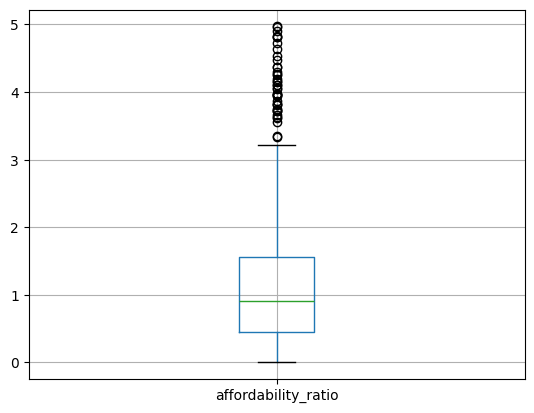

In [ ]:
affordability_df.boxplot('affordability_ratio')

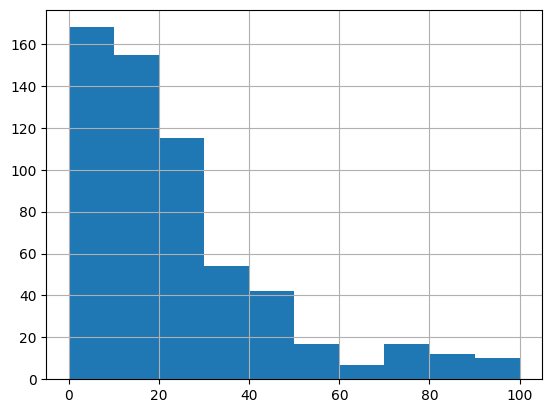

In [17]:
import matplotlib.pyplot as plt

affordability_df['affordability_index'].hist()
plt.show()

In [16]:
affordability_df.to_csv('../data/processed/affordability_index.csv')